In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
groups_software = pd.read_csv('../data/interim/collected_groups_software_df.csv')

In [3]:
ft = groups_software['target ID'].value_counts()
frequency_distribution = groups_software['target ID'].value_counts().sort_values(ascending=False)

In [4]:
ft.unique()

array([41, 29, 27, 21, 14, 13, 12, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

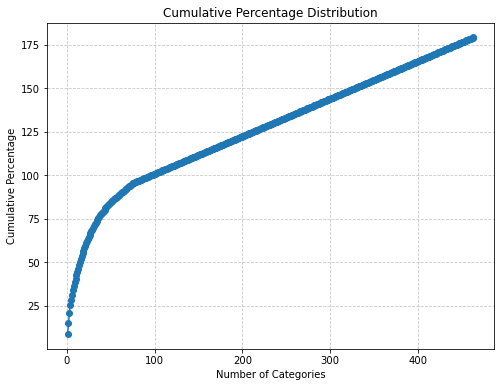

In [5]:
# Calculate the total number of categories
total_categories = len(frequency_distribution)

# Calculate the percentage distribution
percentage_distribution = (frequency_distribution / total_categories) * 100

# Calculate the cumulative percentage
cumulative_percentage = percentage_distribution.cumsum()

# Create a line plot of the cumulative percentage
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.plot(range(1, total_categories + 1), cumulative_percentage, marker='o')

# Add labels and title
plt.xlabel('Number of Categories')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Percentage Distribution')

# Show the plot
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

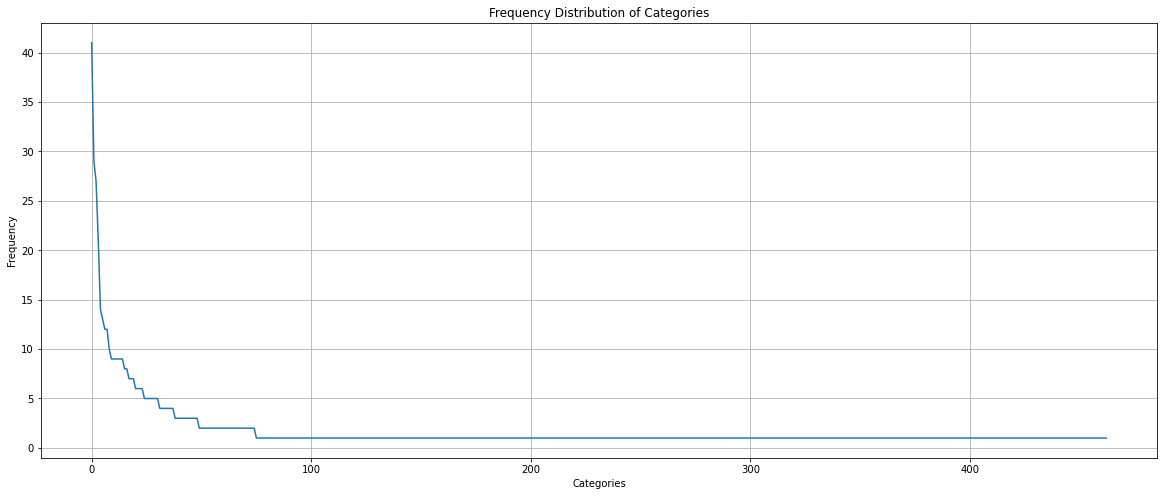

In [6]:
x_positions = np.arange(len(ft))
plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.plot(x_positions, ft.values)
plt.xlabel('Categories')
# plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Categories')
plt.grid()

In [7]:
techniques_software = pd.read_csv('../data/interim/collected_techniques_software_df.csv')

In [8]:
ft = techniques_software['source ID'].value_counts()

In [9]:
ft.unique()

array([72, 71, 53, 51, 47, 46, 45, 44, 42, 41, 40, 39, 37, 36, 35, 34, 33,
       32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

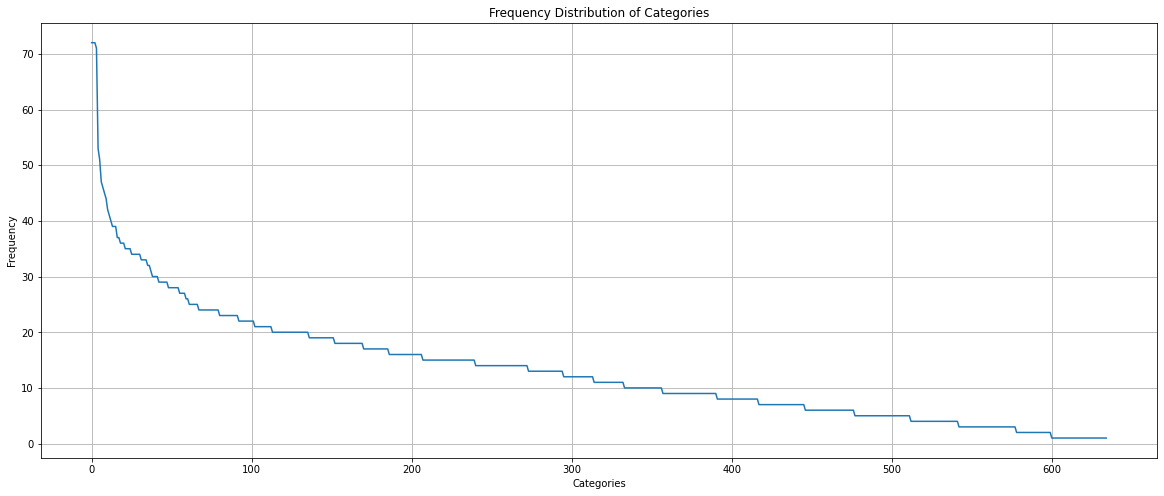

In [10]:
x_positions = np.arange(len(ft))
plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.plot(x_positions, ft.values)
plt.xlabel('Categories')
# plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Categories')
plt.grid()

In [11]:
techniques_mitigations = pd.read_csv('../data/interim/collected_techniques_mitigations_df.csv')

In [12]:
ft = techniques_mitigations['source ID'].value_counts()

In [13]:
ft

source ID
M1026    105
M1018     89
M1056     82
M1047     78
M1038     66
M1042     59
M1022     56
M1031     55
M1040     46
M1027     44
M1017     41
M1032     41
M1037     40
M1028     39
M1030     35
M1051     32
M1041     29
M1054     24
M1021     23
M1045     20
M1024     20
M1035     16
M1049     15
M1015     14
M1048     12
M1029     11
M1050     11
M1046     11
M1057      9
M1053      9
M1013      9
M1043      8
M1052      7
M1025      7
M1036      7
M1033      6
M1016      5
M1020      4
M1019      4
M1034      4
M1044      3
M1039      2
M1055      2
Name: count, dtype: int64

In [14]:
ft.unique()

array([105,  89,  82,  78,  66,  59,  56,  55,  46,  44,  41,  40,  39,
        35,  32,  29,  24,  23,  20,  16,  15,  14,  12,  11,   9,   8,
         7,   6,   5,   4,   3,   2], dtype=int64)

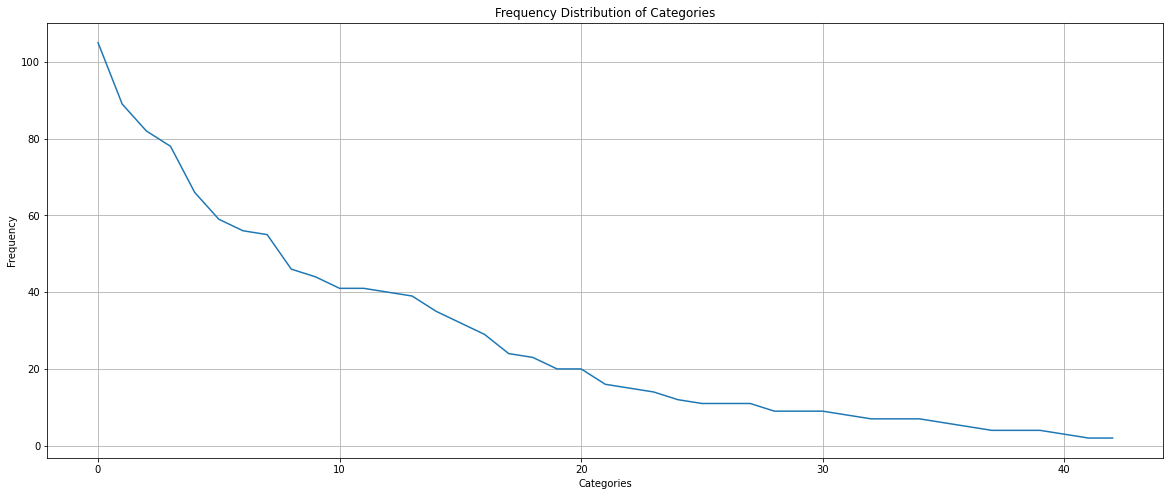

In [15]:
x_positions = np.arange(len(ft))
plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.plot(x_positions, ft.values)
plt.xlabel('Categories')
# plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Categories')
plt.grid()

In [16]:
techniques_detections = pd.read_csv('../data/interim/collected_techniques_detections_df.csv')

In [17]:
ft = techniques_detections['source name'].value_counts()

In [18]:
ft

source name
Command Execution          268
Process Creation           226
Network Traffic Content    108
File Modification          104
OS API Execution            94
                          ... 
Pod Modification             1
Container Enumeration        1
Cloud Storage Metadata       1
Snapshot Enumeration         1
Instance Enumeration         1
Name: count, Length: 105, dtype: int64

In [19]:
ft.unique()

array([268, 226, 108, 104,  94,  91,  86,  72,  65,  61,  54,  47,  44,
        37,  30,  26,  22,  21,  18,  16,  15,  14,  13,  11,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1], dtype=int64)

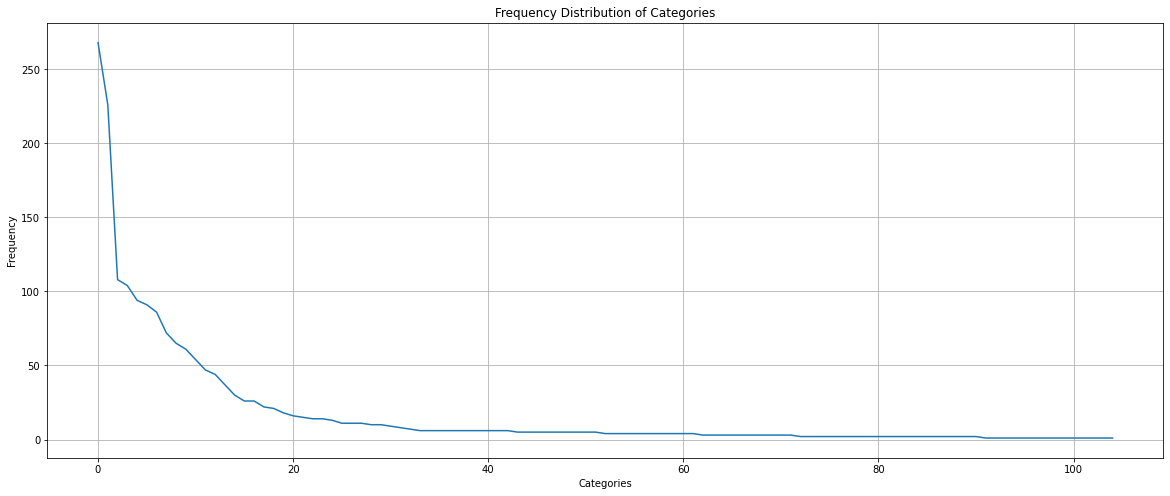

In [20]:
x_positions = np.arange(len(ft))
plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.plot(x_positions, ft.values)
plt.xlabel('Categories')
# plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Categories')
plt.grid()

In [21]:
techni

NameError: name 'techni' is not defined